# I. Abhängigkeit Brands und Channel

In [2]:
#import pipeline as pipe
import pandas as pd
import numpy as np
import glob


#def load_data():
#    data = pipe.pipeline()


def load_preprocess_data():
    path = r'./Data-out' 
    all_files = glob.glob(path + "/hda_dataset_uniform_random_[0-7].csv")
    all_files.sort()
    
    #Load all data
    df = (pd.read_csv(f) for f in all_files)
    
    #Merge all the files with each other
    #Drop all duplicates
    concat_df = pd.concat(df).drop_duplicates().reset_index(drop=True)
    concat_df = concat_df.sort_values(by=['case', 'ts'])
    #reset index
    concat_df = concat_df.reset_index(drop=True)
    #Create a csv file
    #concat_df.to_csv('test1.csv')
    return concat_df

In [3]:
df = load_preprocess_data()
df.head()

,case,event,ts
0,1,Order imported,2018-09-02 00:02:30
1,1,Order checked,2018-09-02 00:02:41
2,1,Address correction,2018-09-02 00:06:21
3,1,Order creation failed (SYS-2),2018-09-02 00:07:00
4,1,Device hand-out,2018-09-03 16:36:00


### Brand-Analyse

In [4]:
brands = pd.read_csv('./Data-out/brands.csv', sep =",")
brands.head()

,pid,BRAND
0,66605,BRAND_0
1,66715,BRAND_0
2,66756,BRAND_0
3,66774,BRAND_0
4,66794,BRAND_0


In [5]:
print("Anzahl verschiedener Brands: {}".format(brands.BRAND.unique().size))

Anzahl verschiedener Brands: 10


In [6]:
group = brands.groupby(['BRAND']).count()
group['brand'] = group.index
group

,pid,brand
BRAND,,
BRAND_0,4715,BRAND_0
BRAND_1,205293,BRAND_1
BRAND_2,10544,BRAND_2
BRAND_3,193,BRAND_3
BRAND_4,1657,BRAND_4
BRAND_5,9,BRAND_5
BRAND_6,26359,BRAND_6
BRAND_7,14037,BRAND_7
BRAND_8,62,BRAND_8


In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(group['brand'], group['pid'])


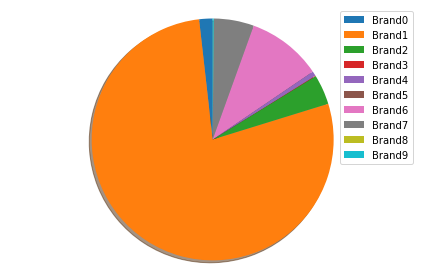

In [35]:

myArr = group['pid'].to_numpy()


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
labels = ['Brand0', 'Brand1', 'Brand2', 'Brand3', 'Brand4', 'Brand5', 'Brand6', 'Brand7', 'Brand8', 'Brand9']
patches, texts = plt.pie(myArr, startangle=90, shadow=True)
#, autopct='%1.1f%%', pctdistance=0.7 , shadow=True
plt.legend(patches, labels, loc="best")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [9]:
df1 = df.join(brands.set_index('pid'), on='case')
df1[df1['BRAND'] == 'BRAND_7' ]

,case,event,ts,BRAND
709923,131476,Export from online shop,2018-10-19 16:18:34,BRAND_7
709924,131476,Order imported,2018-10-23 15:38:41,BRAND_7
709925,131476,Address correction,2018-10-23 15:40:36,BRAND_7
709926,131476,Order checked,2018-10-23 15:42:27,BRAND_7
709927,131476,Ready for payment processing,2018-10-23 15:42:27,BRAND_7
...,...,...,...,...
1405555,263239,Delivery approved,2018-12-01 23:48:20,BRAND_7
1405556,263239,In delivery,2018-12-01 23:48:24,BRAND_7
1405557,263239,Ready to deliver,2018-12-03 05:04:35,BRAND_7
1405558,263239,Delivered,2018-12-03 09:35:03,BRAND_7


# II. Zusammenhang zwischen Lieferzeit und Retoure

### Zuerst INNER-JOIN der Tupel (Order Checked | Delivered)

#### dann Zeitdifferenz errechnen und nach dieser sortieren

In [4]:
ordered_data = df[(df['event'] == "Order checked")]
delivered_data = df[(df['event'] == "Delivered")]

od_data = pd.merge(ordered_data, delivered_data, on="case", how="inner")
od_data = od_data[['case', 'event_x', 'event_y', 'ts_x', 'ts_y']]
od_data['diff'] = pd.to_datetime(od_data['ts_y']) - pd.to_datetime(od_data['ts_x'])
od_data['diff'] = od_data['diff']/np.timedelta64(1, 'D')
od_data = od_data.sort_values(by=['diff'], ascending=False)
od_data

,case,event_x,event_y,ts_x,ts_y,diff
32548,71316,Order checked,Delivered,2018-10-08 09:39:14,2018-11-21 08:16:08,43.942292
3560,7652,Order checked,Delivered,2018-09-06 12:03:31,2018-10-17 15:01:44,41.123762
23345,49804,Order checked,Delivered,2018-09-27 17:43:39,2018-11-05 17:46:24,39.001910
46580,106517,Order checked,Delivered,2018-10-17 03:21:36,2018-11-21 15:34:33,35.508993
46581,106517,Order checked,Delivered,2018-10-17 03:21:38,2018-11-21 15:34:33,35.508970
...,...,...,...,...,...,...
50837,117103,Order checked,Delivered,2018-10-19 14:13:38,2018-10-19 15:18:49,0.045266
50752,116926,Order checked,Delivered,2018-10-19 13:28:12,2018-10-19 14:32:47,0.044850
50844,117124,Order checked,Delivered,2018-10-19 14:15:17,2018-10-19 15:19:25,0.044537
50775,116981,Order checked,Delivered,2018-10-19 14:08:03,2018-10-19 15:02:25,0.037755


### Evtl. Retoure dem DataFrame als Spalte hinzugefuegt

In [10]:
ordered_data = df[(df['event'] == "Order checked")]
delivered_data = df[(df['event'] == "Delivered")]
return_data = df[(df['event'] == "Return delivery initiated")]
return_data = return_data.drop(columns=['ts'])

od_data = pd.merge(ordered_data, delivered_data, on="case", how="inner")

od_data = od_data[['case', 'event_x', 'event_y', 'ts_x', 'ts_y']]

od_data['diff'] = pd.to_datetime(od_data['ts_y']) - pd.to_datetime(od_data['ts_x'])
od_data['diff'] = od_data['diff']/np.timedelta64(1, 'D')
od_data = od_data.sort_values(by=['diff'], ascending=False)

od_data = pd.merge(od_data, return_data, on="case", how="outer")
od_data = od_data.rename(columns={'event': 'returned'})
od_data = od_data.fillna(0)
od_data = od_data.replace('Return delivery initiated', 1)

od_data2 = od_data[od_data['returned'] == 1]

od_data

,case,event_x,event_y,ts_x,ts_y,diff,returned
0,71316,Order checked,Delivered,2018-10-08 09:39:14,2018-11-21 08:16:08,43.942292,0
1,7652,Order checked,Delivered,2018-09-06 12:03:31,2018-10-17 15:01:44,41.123762,1
2,49804,Order checked,Delivered,2018-09-27 17:43:39,2018-11-05 17:46:24,39.001910,0
3,106517,Order checked,Delivered,2018-10-17 03:21:36,2018-11-21 15:34:33,35.508993,0
4,106517,Order checked,Delivered,2018-10-17 03:21:38,2018-11-21 15:34:33,35.508970,0
...,...,...,...,...,...,...,...
114435,117103,Order checked,Delivered,2018-10-19 14:13:38,2018-10-19 15:18:49,0.045266,0
114436,116926,Order checked,Delivered,2018-10-19 13:28:12,2018-10-19 14:32:47,0.044850,0
114437,117124,Order checked,Delivered,2018-10-19 14:15:17,2018-10-19 15:19:25,0.044537,0
114438,116981,Order checked,Delivered,2018-10-19 14:08:03,2018-10-19 15:02:25,0.037755,0


### Visualisierung

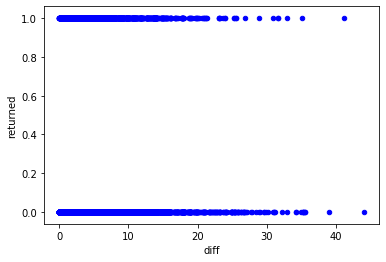

In [12]:
import matplotlib
import matplotlib.pyplot as plt

od_data.plot(kind='scatter',x='diff', y='returned', color='blue')
plt.show()


### Verhältnis zwischen Bestellungen und Retouren innerhalb von Intervallen errechnet

#### Intervall 1: unter 1 Tage
#### Intervall 2: zwischen 1 und 5 Tage
#### Intervall 3: über 5 Tage

In [34]:
range1 = od_data[(od_data['diff'] < 1)]['diff'].count()
print("Bestellungen Intervall 1: {} cases".format(range1))
range2 = od_data[(od_data['diff'] > 1)  & (od_data['diff'] < 5)]['diff'].count()
print("Bestellungen Intervall 2: {} cases".format(range2))
range3 = od_data[(od_data['diff'] > 5)]['diff'].count()
print("Bestellungen Intervall 3: {} cases".format(range3))

range4 = od_data2[(od_data2['diff'] < 1)]['diff'].count()
print("Retouren Intervall 1: {} cases".format(range4))
range5 = od_data2[(od_data2['diff'] > 1)  & (od_data2['diff'] < 5)]['diff'].count()
print("Retouren Intervall 2: {} cases".format(range5))
range6 = od_data2[(od_data2['diff'] > 5)]['diff'].count()
print("Retouren Intervall 3: {} cases".format(range6))

result1 = range4/range1
result2 = range5/range2
result3 = range6/range3

print("Durchschnitt unter 1 Tag: {:.2%} ".format(result1))
print("Durchschnitt zw. 1 und 5 Tage: {:.2%}".format(result2))
print("Durchschnitt über 5 tage: {:.2%}".format(result3))

Bestellungen Intervall 1: 59228 cases
Bestellungen Intervall 2: 46173 cases
Bestellungen Intervall 3: 9038 cases
Retouren Intervall 1: 8436 cases
Retouren Intervall 2: 5270 cases
Retouren Intervall 3: 1139 cases
Durchschnitt unter 1 Tag: 14.24% 
Durchschnitt zw. 1 und 5 Tage: 11.41%
Durchschnitt über 5 tage: 12.60%


### Verhältnis zwischen Stornierung und Nicht-auf-Lager

In [18]:
inarrears_data = df[(df['event'] == "Goods in arrears")]
inarrears_data = inarrears_data.drop(columns=['ts'])

inarrears_data

,case,event
63,7,Goods in arrears
102,12,Goods in arrears
116,15,Goods in arrears
143,17,Goods in arrears
157,18,Goods in arrears
...,...,...
1405539,263234,Goods in arrears
1405548,263235,Goods in arrears
1405568,263240,Goods in arrears
1405594,263244,Goods in arrears


In [47]:
cancel_data = df[(df['event'] == "Cancelled (SYS-2)")]
cancel_data = cancel_data.drop(columns=['ts'])
inarrears_data = df[(df['event'] == "Goods in arrears")]
inarrears_data = inarrears_data.drop(columns=['ts'])
ci_data = pd.merge(inarrears_data, cancel_data, on="case", how="inner")
ci_count = ci_data.case.count()
ci_data

,case,event_x,event_y
0,82,Goods in arrears,Cancelled (SYS-2)
1,234,Goods in arrears,Cancelled (SYS-2)
2,290,Goods in arrears,Cancelled (SYS-2)
3,541,Goods in arrears,Cancelled (SYS-2)
4,591,Goods in arrears,Cancelled (SYS-2)
...,...,...,...
357,260046,Goods in arrears,Cancelled (SYS-2)
358,260896,Goods in arrears,Cancelled (SYS-2)
359,261214,Goods in arrears,Cancelled (SYS-2)
360,261602,Goods in arrears,Cancelled (SYS-2)


In [48]:
cancel_data = df[(df['event'] == "Cancelled (SYS-2)")]
cancel_data = cancel_data.drop(columns=['ts'])
cancel_count = cancel_data.case.count()
cancel_data

,case,event
566,82,Cancelled (SYS-2)
1425,234,Cancelled (SYS-2)
1746,290,Cancelled (SYS-2)
3413,541,Cancelled (SYS-2)
3787,591,Cancelled (SYS-2)
...,...,...
1396175,261214,Cancelled (SYS-2)
1397961,261602,Cancelled (SYS-2)
1398185,261650,Cancelled (SYS-2)
1398358,261687,Cancelled (SYS-2)


In [72]:
percent = ci_count/cancel_count
print("Cancellations with goods in arrears: {:.2%} ".format(percent))


Cancellations with goods in arrears: 28.62% 


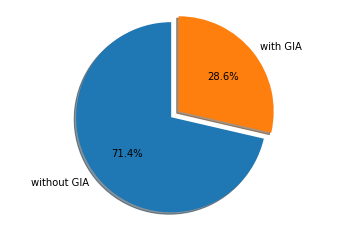

In [71]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['without GIA', 'with GIA']
sizes = [100-percent*100, percent*100]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()